IDENTIFYING THE ACUURACY ,LOSS VAL_ACC,VAL_LOSS AND MODEL ACCURACY GRAPH

Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 247ms/step - accuracy: 0.4477 - loss: 1.0447 - val_accuracy: 0.5671 - val_loss: 0.9346
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.6027 - loss: 0.9154 - val_accuracy: 0.5844 - val_loss: 0.8927
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.6028 - loss: 0.8452 - val_accuracy: 0.6667 - val_loss: 0.8402
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.6523 - loss: 0.7920 - val_accuracy: 0.6710 - val_loss: 0.7947
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - accuracy: 0.6741 - loss: 0.7544 - val_accuracy: 0.7056 - val_loss: 0.7672
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.7204 - loss: 0.6811 - val_accuracy: 0.7100 - val_loss: 0.7439
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 263ms/step - accuracy: 0.7508 - loss: 0.6398 - val_accuracy: 0.6883 - val_loss: 0.7157
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 296ms/step - accuracy: 0.7510 - loss: 0.6163 - val_accuracy

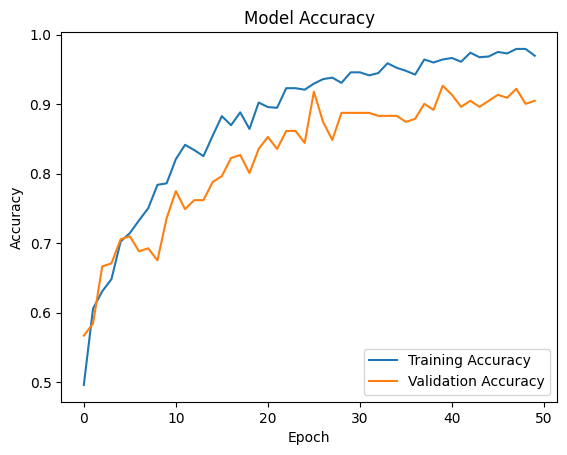

In [11]:
# Install necessary libraries
!pip install kagglehub librosa tensorflow keras scikit-learn

import kagglehub
import librosa
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Download the RAVDESS dataset using kagglehub
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to dataset files:", path)

# Function to extract MFCC features from audio files
def extract_features(file_path, max_pad_len=174):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    # Pad or truncate MFCCs to fixed length
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc.T

# Emotions to classify
emotions = ['angry', 'happy', 'sad']

# Prepare the dataset
X = []
y = []

# Traverse the downloaded dataset
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            # Extract emotion from the file path using a more robust method
            # Assuming file names are in the format: 'Actor_03-01-01-01-01-01-01.wav'
            # Emotion is represented by the third part of the file name (01, 02, 03, etc.)
            try:
                emotion_label_code = file.split('-')[2]  # Get the third part
                if emotion_label_code == '05':  # Angry
                    emotion_label = 'angry'
                elif emotion_label_code == '03':  # Happy
                    emotion_label = 'happy'
                elif emotion_label_code == '04':  # Sad
                    emotion_label = 'sad'
                else:
                    emotion_label = None

                # Process only recognized emotions
                if emotion_label:
                    try:
                        features = extract_features(file_path)
                        X.append(features)
                        y.append(emotion_label)
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")

            except IndexError:
                print(f"Warning: Unexpected file name format: {file}")

# Convert features and labels to numpy arrays
X = np.array(X)
y = np.array(y)

# Check if y is empty before encoding
if y.size == 0:
    print("Error: No audio files found or no files matched the emotion labels. Please check your dataset and file naming conventions.")
else:
    # Encode the labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # One-hot encode the labels
    y_one_hot = to_categorical(y_encoded)

    # ... (rest of your code)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Reshape the data for LSTM input (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(emotions), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()


**IDENTIFYING WHICH AUDIO FILES ARE HAPPY ,ANGRY AND SAD **

In [12]:
!pip install kagglehub librosa

import kagglehub
import librosa
import os

# Download the RAVDESS dataset using kagglehub
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to dataset files:", path)

# Emotions to classify
emotions = ['angry', 'happy', 'sad']

# Dictionary to store audio files for each emotion
emotion_files = {emotion: [] for emotion in emotions}

# Traverse the downloaded dataset
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            # Extract emotion from the file path using a more robust method
            # Assuming file names are in the format: 'Actor_03-01-01-01-01-01-01.wav'
            # Emotion is represented by the third part of the file name (01, 02, 03, etc.)
            try:
                emotion_label_code = file.split('-')[2]  # Get the third part
                if emotion_label_code == '05':  # Angry
                    emotion_label = 'angry'
                elif emotion_label_code == '03':  # Happy
                    emotion_label = 'happy'
                elif emotion_label_code == '04':  # Sad
                    emotion_label = 'sad'
                else:
                    emotion_label = None

                # Process only recognized emotions
                if emotion_label:
                    emotion_files[emotion_label].append(file_path)

            except IndexError:
                print(f"Warning: Unexpected file name format: {file}")

# Print audio files for each emotion
for emotion, files in emotion_files.items():
    print(f"\nAudio files for {emotion}:")
    for file_path in files:
        print(file_path)

Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1

Audio files for angry:
/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/Actor_05/03-01-05-01-01-01-05.wav
/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/Actor_05/03-01-05-01-02-02-05.wav
/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/Actor_05/03-01-05-01-02-01-05.wav
/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/Actor_05/03-01-05-02-01-02-05.wav
/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/Actor_05/03-01-05-02-02-01-05.wav
/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/Actor_05/03-01-05-01-01-02-05.wav
/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/Actor_05/03-01-05-02-01-01-05.wav
/root/.cache/kagglehub/data

**PRINTING EMOTIONS FOR EACH AUDIO FILES**

In [20]:
!pip install kagglehub librosa

import kagglehub
import librosa
import os

# Download the RAVDESS dataset using kagglehub
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to dataset files:", path)

# Emotions to classify
emotions = ['angry', 'happy', 'sad']

# Traverse the downloaded dataset
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            # Extract emotion from the file path using a more robust method
            # Assuming file names are in the format: 'Actor_03-01-01-01-01-01-01.wav'
            # Emotion is represented by the third part of the file name (01, 02, 03, etc.)
            try:
                emotion_label_code = file.split('-')[2]  # Get the third part
                if emotion_label_code == '05':  # Angry
                    emotion_label = 'angry'
                elif emotion_label_code == '03':  # Happy
                    emotion_label = 'happy'
                elif emotion_label_code == '04':  # Sad
                    emotion_label = 'sad'
                else:
                    emotion_label = None

                # Process only recognized emotions
                if emotion_label:
                    print(f"File: {file}, Emotion: {emotion_label}")

            except IndexError:
                print(f"Warning: Unexpected file name format: {file}")

Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1
File: 03-01-05-01-01-01-05.wav, Emotion: angry
File: 03-01-03-02-01-02-05.wav, Emotion: happy
File: 03-01-04-02-01-01-05.wav, Emotion: sad
File: 03-01-04-02-01-02-05.wav, Emotion: sad
File: 03-01-05-01-02-02-05.wav, Emotion: angry
File: 03-01-04-01-02-02-05.wav, Emotion: sad
File: 03-01-03-02-01-01-05.wav, Emotion: happy
File: 03-01-04-01-02-01-05.wav, Emotion: sad
File: 03-01-04-01-01-02-05.wav, Emotion: sad
File: 03-01-05-01-02-01-05.wav, Emotion: angry
File: 03-01-05-02-01-02-05.wav, Emotion: angry
File: 03-01-04-01-01-01-05.wav, Emotion: sad
File: 03-01-03-01-02-02-05.wav, Emotion: happy
File: 03-01-05-02-02-01-05.wav, Emotion: angry
File: 03-01-05-01-01-02-05.wav, Emotion: angry
File: 03-01-05-02-01-01-05.wav, Emotion: angry
File: 03-01-03-01-01-02-05.wav, Emotion: happy
File: 03-01-03-02-02-02-05.wav, Emotion: happy
File: 03-01-03-02-02-01-05.wav, Emotion: happy
File: 03-0

In [ ]:
dditional

**bold text**

In [21]:
!pip install kagglehub librosa

import kagglehub
import librosa
import os

# Download the RAVDESS dataset using kagglehub
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to dataset files:", path)

# Emotions to classify
emotions = ['angry', 'happy', 'sad']

# Emoji mapping
emotion_emojis = {
    'angry': '😠',
    'happy': '😊',
    'sad': '😢'
}

# Traverse the downloaded dataset
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            try:
                emotion_label_code = file.split('-')[2]
                if emotion_label_code == '05':
                    emotion_label = 'angry'
                elif emotion_label_code == '03':
                    emotion_label = 'happy'
                elif emotion_label_code == '04':
                    emotion_label = 'sad'
                else:
                    emotion_label = None

                if emotion_label:
                    emoji = emotion_emojis.get(emotion_label, '')  # Get emoji or empty string
                    print(f"File: {file}, Emotion: {emotion_label} {emoji}")

            except IndexError:
                print(f"Warning: Unexpected file name format: {file}")

Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1
File: 03-01-05-01-01-01-05.wav, Emotion: angry 😠
File: 03-01-03-02-01-02-05.wav, Emotion: happy 😊
File: 03-01-04-02-01-01-05.wav, Emotion: sad 😢
File: 03-01-04-02-01-02-05.wav, Emotion: sad 😢
File: 03-01-05-01-02-02-05.wav, Emotion: angry 😠
File: 03-01-04-01-02-02-05.wav, Emotion: sad 😢
File: 03-01-03-02-01-01-05.wav, Emotion: happy 😊
File: 03-01-04-01-02-01-05.wav, Emotion: sad 😢
File: 03-01-04-01-01-02-05.wav, Emotion: sad 😢
File: 03-01-05-01-02-01-05.wav, Emotion: angry 😠
File: 03-01-05-02-01-02-05.wav, Emotion: angry 😠
File: 03-01-04-01-01-01-05.wav, Emotion: sad 😢
File: 03-01-03-01-02-02-05.wav, Emotion: happy 😊
File: 03-01-05-02-02-01-05.wav, Emotion: angry 😠
File: 03-01-05-01-01-02-05.wav, Emotion: angry 😠
File: 03-01-05-02-01-01-05.wav, Emotion: angry 😠
File: 03-01-03-01-01-02-05.wav, Emotion: happy 😊
File: 03-01-03-02-02-02-05.wav, Emotion: happy 😊
File: 03-01-03-02-02-